In [1]:
import os
default_n_threads = 8
os.environ['OPENBLAS_NUM_THREADS'] = f"{default_n_threads}"
os.environ['MKL_NUM_THREADS'] = f"{default_n_threads}"
os.environ['OMP_NUM_THREADS'] = f"{default_n_threads}"


import h5py
import numpy as np
import pandas as pd
import torch
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from lightning import Trainer
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    average_precision_score,
    classification_report,
    confusion_matrix,
    matthews_corrcoef
)
from sklearn.model_selection import StratifiedGroupKFold, cross_val_predict
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

from src.data.lightning_glyco import ImpGroupedBatchSampler

from src.models import GlycoModel

In [2]:
def prepare_data(glyco_type: str):
    glyco_to_class = {
        'N': 1,
        'O': 2
        }
    glyco_class = glyco_type
    glyco_sites = pd.read_csv(f'data/glyco/{glyco_type}/train_rr_df.csv')
    glyco_sites = glyco_sites[(glyco_sites['label'] == glyco_to_class[glyco_class]) | (glyco_sites['label'] == 0)]

    glyco_sites["label"] = glyco_sites["label"].apply(lambda x: 1 if x >= 1 else 0)
    if glyco_class == 'N':
        glyco_sites = glyco_sites[glyco_sites["AA"] == 'N']
    else:
        glyco_sites = glyco_sites[(glyco_sites["AA"] == 'S') | (glyco_sites["AA"] == 'T')]
    #glyco_sites, labels = ros.fit_resample(glyco_sites, labels)
    glyco_sites.reset_index(drop=True, inplace=True)
    input_features = np.empty((len(glyco_sites), 2304))
    for idx, (pid, pos) in tqdm(enumerate(zip(glyco_sites['PID'], glyco_sites['Position']))):
        input_feature = np.empty(2304)
        with h5py.File(f'data/glyco/glyco_embeddings.h5', 'r') as p5, h5py.File(f'data/glyco/glyco_esm_embeddings.h5', 'r') as esm:
            try:
                #processed_pids = [pid.replace("-", "_").replace(".", "_") for pid in pids] 
                input_feature = np.concatenate([p5[pid.replace('-', '_').replace('.','_')][()][pos - 1], esm[pid.replace("_", "-")][()][pos - 1]])
            except:
                
                continue
            input_features[idx] = input_feature
    mask = np.all(input_features != 0, axis=1)
    input_features = input_features[mask]
    labels = np.array(glyco_sites['label'])[mask]
    print(np.sum(~mask))
    print(glyco_sites['label'][mask].value_counts())
    print(glyco_sites['label'].value_counts())
    input_features = input_features.astype(np.float32)
    labels = labels.astype(np.float16)
    return input_features, labels, glyco_sites, mask


In [3]:
N_input_features, N_labels, N_glyco_sites, N_mask = prepare_data('N')
O_input_features, O_labels, O_glyco_sites, O_mask = prepare_data('O')

19030it [02:05, 151.87it/s]


840
label
0    11284
1     6906
Name: count, dtype: int64
label
0    11819
1     7211
Name: count, dtype: int64


86467it [03:35, 401.79it/s]


3556
label
0    79243
1     3668
Name: count, dtype: int64
label
0    82624
1     3843
Name: count, dtype: int64


### Visualize train data

In [4]:
# take a random subset and use UMAP to visualize
import umap
import matplotlib.pyplot as plt
import seaborn as sns

#use all positve and subsample same amount of negative samples for N 
N_subset_mask = np.random.choice(np.where(N_labels == 1)[0], 1000, replace=False)
N_subset_mask = np.concatenate([N_subset_mask, np.random.choice(np.where(N_labels == 0)[0], 1000, replace=False)])

#use all positve and subsample same amount of negative samples for O
O_subset_mask = np.random.choice(np.where(O_labels == 1)[0], 1000, replace=False)
O_subset_mask = np.concatenate([O_subset_mask, np.random.choice(np.where(O_labels == 0)[0], 1000, replace=False)])

#plot separately note that the first 1024 values are prot5 embeddings and the last 1280 are esm embeddings
# so we can plot them separately
N_umap_p5 = umap.UMAP(n_neighbors=20, min_dist=0.25).fit_transform(N_input_features[N_subset_mask, :1024])
N_umap_esm = umap.UMAP(n_neighbors=20, min_dist=0.25).fit_transform(N_input_features[N_subset_mask, 1024:])

O_umap_p5 = umap.UMAP(n_neighbors=20, min_dist=0.25).fit_transform(O_input_features[O_subset_mask, :1024])
O_umap_esm = umap.UMAP(n_neighbors=20, min_dist=0.25).fit_transform(O_input_features[O_subset_mask, 1024:])

N_umap = umap.UMAP(n_neighbors=20, min_dist=0.25).fit_transform(N_input_features[N_subset_mask])
O_umap = umap.UMAP(n_neighbors=20, min_dist=0.25).fit_transform(O_input_features[O_subset_mask])


2024-10-25 14:43:00.741324: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-25 14:43:00.897129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-25 14:43:01.006499: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-25 14:43:01.038541: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-25 14:43:01.274333: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instru

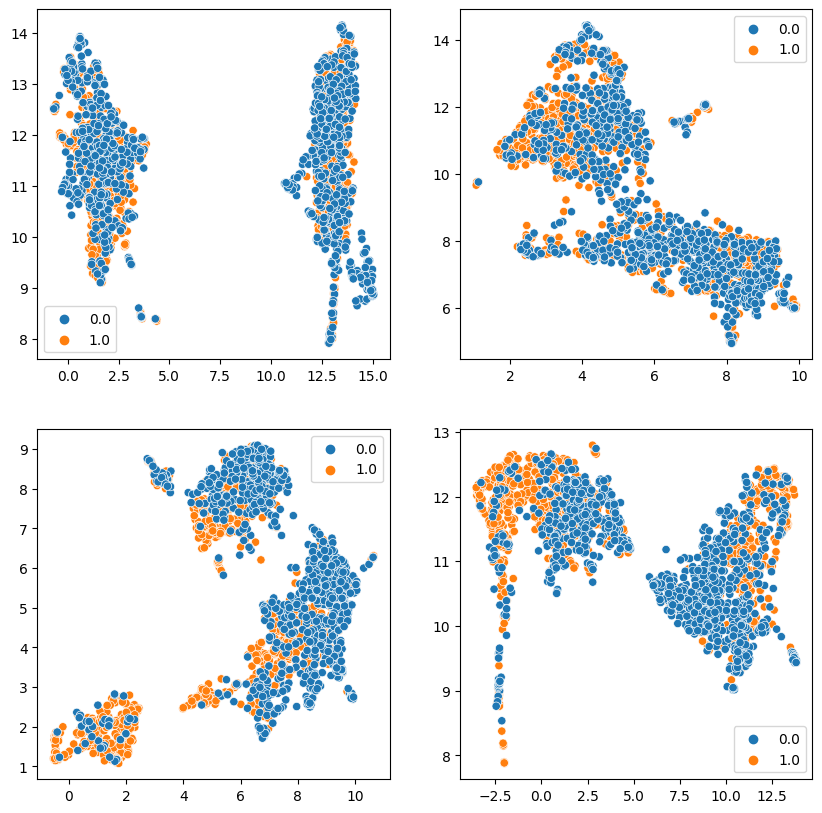

In [19]:
fix, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.scatterplot(x=N_umap_p5[:,0], y=N_umap_p5[:,1], hue=N_labels[N_subset_mask], ax=ax[0, 0])
sns.scatterplot(x=N_umap_esm[:,0], y=N_umap_esm[:,1], hue=N_labels[N_subset_mask], ax=ax[0, 1])
sns.scatterplot(x=O_umap_p5[:,0], y=O_umap_p5[:,1], hue=O_labels[O_subset_mask], ax=ax[1, 0])
sns.scatterplot(x=O_umap_esm[:,0], y=O_umap_esm[:,1], hue=O_labels[O_subset_mask], ax=ax[1, 1])
plt.show()

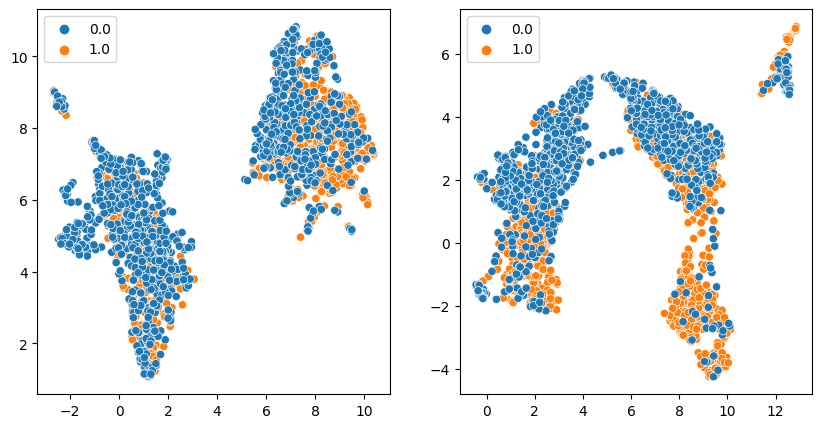

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(x=N_umap[:,0], y=N_umap[:,1], hue=N_labels[N_subset_mask], ax=ax[0])
sns.scatterplot(x=O_umap[:,0], y=O_umap[:,1], hue=O_labels[O_subset_mask], ax=ax[1])
plt.show()

### HP ratios 

In [4]:
!export OPENBLAS_NUM_THREADS=1

In [5]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings("ignore")


def smote_embeddings(embeddings, n_samples, k_neighbors=5):
    # Step 1: Find k-nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=k_neighbors).fit(embeddings)
    synthetic_samples = []
    
    for i in range(n_samples):
        # Randomly choose a sample from embeddings
        idx = np.random.randint(0, len(embeddings))
        sample = embeddings[idx]
        
        # Find nearest neighbors
        neighbors = nbrs.kneighbors([sample], return_distance=False)[0]
        neighbor_idx = np.random.choice(neighbors[1:])  # Avoid the sample itself
        neighbor = embeddings[neighbor_idx]
        
        # Step 2: Interpolation
        lambda_ = np.random.rand()  # Random value between 0 and 1
        synthetic_sample = sample + lambda_ * (neighbor - sample)
        
        synthetic_samples.append(synthetic_sample)
    
    return np.array(synthetic_samples)


In [ ]:
class Glycodataset(Dataset):
    def __init__(self, X, y, pids):
        super().__init__()
        self.X = X
        self.y = y
        self.pids = pids
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.pids[idx]

In [23]:
# test how the synthetic samples influence model performance 
# select a fixed validation set and train a model once with undersampling negative samples and not touching positive samples
# and once with synthetic samples and undersampling the negative samples to match the amount of postive samples
# use a function so we can apply to both N and O
def test_synthetic_oversampling(glyco_class: str, input_features, labels, pids):
    pids = np.array(pids)
    # split the data into train and test
    ros = RandomOverSampler(random_state=42, sampling_strategy=0.8)
    rus = RandomUnderSampler(random_state=42)
    # need to use the original data for synthetic samples and undersample after adding the synthetic samples
    skf = StratifiedGroupKFold(n_splits=5)
    for train_index, test_index in skf.split(input_features, labels, groups=pids):
        break
    # train a model without synthetic samples and undersampling
    y_train = labels[train_index]
    y_test = labels[test_index]
    pids_train = pids[train_index]
    pids_test = pids[test_index]
    X_train = input_features[train_index]
    X_test = input_features[test_index]
    
    #train_idx, y_train_u = ros.fit_resample(np.arange(len(y_train)).reshape(-1, 1), y_train)
    val_idx, y_test = rus.fit_resample(np.arange(len(y_test)).reshape(-1, 1), y_test)   
    #train_idx = train_idx.flatten()
    val_idx = val_idx.flatten()
    #X_train_u = X_train[train_idx]    
    #pids_train_u = pids_train[train_idx]
    #y_train_u = y_train_u.flatten()
    X_test = X_test[val_idx]
    pids_test = pids_test[val_idx]
    y_test = y_test.flatten()
    
     
    model = GlycoModel(num_classes=2, input_dim=2304,)
    
    train_dl = DataLoader(Glycodataset(X_train, y_train, pids_train), 
                                    batch_sampler=ImpGroupedBatchSampler(pids_train, 64))
    
    val_dl = DataLoader(Glycodataset(X_test, y_test, pids_test), shuffle=False, batch_size=1)
    trainer = Trainer(max_epochs=20, num_sanity_val_steps=1, callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=4), ModelCheckpoint(monitor='val_loss', mode='min', save_top_k=1)])
    trainer.fit(model, train_dl, val_dl)
    y_pred = trainer.predict(ckpt_path='best', dataloaders=val_dl)
    
    print('Without synthetic samples\n')
    print(np.unique(y_train, return_counts=True))
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(matthews_corrcoef(y_test, y_pred))
    print(average_precision_score(y_test, y_pred))
    # train a model with oversampling positive samples
    
    ros_idx, y_train_o = ros.fit_resample(np.arange(len(y_train)).reshape(-1, 1), y_train)
    X_train_o = X_train[ros_idx.squeeze()]
    pids_train_o = pids_train[ros_idx.squeeze()]
    
    train_dl = DataLoader(Glycodataset(X_train_o, y_train_o, pids_train_o), 
                                    batch_sampler=ImpGroupedBatchSampler(pids_train_o, 64))
    model = GlycoModel(num_classes=2, input_dim=2304,)
    trainer = Trainer(max_epochs=20, num_sanity_val_steps=1, callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=4), ModelCheckpoint(monitor='val_loss', mode='min', save_top_k=1)])
    trainer.fit(model, train_dl, val_dl)
    y_pred = trainer.predict(ckpt_path='best', dataloaders=val_dl)  
    print('With oversampling positive samples\n')
    print(np.unique(y_train_o, return_counts=True))
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(matthews_corrcoef(y_test, y_pred))
    print(average_precision_score(y_test, y_pred))
    
    
    # train a model with synthetic samples

    synthetic_samples = smote_embeddings(X_train[y_train == 1], 2000)
    #oversampler = RandomOverSampler(sampling_strategy=0.5)
    pids_train = np.concatenate([pids_train, np.repeat('synth', len(synthetic_samples))])
    X_train = np.concatenate([X_train, synthetic_samples])
    y_train = np.concatenate([y_train, np.ones(len(synthetic_samples))])
    
    #idx, y_train = ros.fit_resample(np.arange(len(y_train)).reshape(-1, 1), y_train)
    #X_train = X_train[idx.squeeze()]
    #pids_train = pids_train[idx.squeeze()]

    
    train_dl = DataLoader(Glycodataset(X_train, y_train, pids_train), 
                                    batch_sampler=ImpGroupedBatchSampler(pids_train, 64))
    model = GlycoModel(num_classes=2, input_dim=2304,)
    trainer = Trainer(max_epochs=20, num_sanity_val_steps=1, callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=4), ModelCheckpoint(monitor='val_loss', mode='min', save_top_k=1)])
    trainer.fit(model, train_dl, val_dl)
    y_pred = trainer.predict(ckpt_path='best', dataloaders=val_dl)
    print('With synthetic samples\n')
    print(f'Classes train{np.unique(y_train, return_counts=True)}')
    print(f'Synthetic samples {len(synthetic_samples)}')
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(matthews_corrcoef(y_test, y_pred))
    print(average_precision_score(y_test, y_pred))
    
    

In [ ]:
test_synthetic_oversampling('N', N_input_features, N_labels, N_glyco_sites['PID'][N_mask])

In [18]:
np.unique(O_labels, return_counts=True)

(array([0., 1.], dtype=float16), array([79243,  3668]))

In [ ]:

    
def hp_tune_ratio(glyco_class: str, input_features, labels, pids):
    if glyco_class == 'N':
        ratios = [0.62, 0.8, 1, 1.2, 1.4, 1.6]
    else:
        ratios = [0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.2, 1.4, 1.6, 1.8, 2]
    oversample_ratios = [1, 1.1, 1.3, 1.5, 1.7, 2]
    pids = np.array(pids)
    sfold = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
    train_idx, test_idx = next(sfold.split(input_features, labels, groups=pids))
    X_train, X_test = input_features[train_idx], input_features[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]
    pids_train = pids[train_idx]
    pids_test = pids[test_idx]
    ros = RandomUnderSampler(random_state=42)
    
    test_idx = np.arange(len(y_test))
    test_idx, y_test = ros.fit_resample(test_idx.reshape(-1, 1), y_test)
    test_idx = test_idx.squeeze()
    X_test = X_test[test_idx]
    pids_test = pids_test[test_idx] 
    test_dataset = Glycodataset(X_test, y_test, pids_test)
    #perform grid search for best ratio
    best_ratio = 0
    best_score = 0
    best_oversample_ratio = 0
    best_model = None
    for ratio in ratios:
        # the negative class is undersampled proportionally to the positive class
        ros = RandomUnderSampler(sampling_strategy={0: int(y_train[y_train == 1].shape[0] * ratio), 
                                                    1: y_train[y_train == 1].shape[0]}, random_state=42)
        train_idx_split = np.arange(len(y_train)) 
        train_idx_split, y_train_split = ros.fit_resample(train_idx_split.reshape(-1, 1), y_train)
        train_idx_split = train_idx_split.squeeze()
        X_train_split = X_train[train_idx_split]
        pids_train_split= pids_train[train_idx_split] 
        for oversample_ratio in oversample_ratios:
            random_oversampler = RandomOverSampler(sampling_strategy={0: y_train_split[y_train_split == 0].shape[0], 
                                                                      1: int(y_train_split[y_train_split == 1].shape[0] * oversample_ratio)}, random_state=42)
            os_index, y_train_split_os = random_oversampler.fit_resample(np.arange(len(y_train_split)).reshape(-1, 1), y_train_split)
            os_index = os_index.squeeze()
            X_train_split_os = X_train_split[os_index]
            pids_train_split_os = pids_train_split[os_index]
            trainer = Trainer(max_epochs=20, 
                              enable_progress_bar=False,
                              num_sanity_val_steps=1, 
                              callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=2), ModelCheckpoint(monitor='val_loss', mode='min', save_top_k=1)])
            sfold_inner = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=42)
            train_idx_inner, val_idx = next(sfold_inner.split(X_train_split_os, y_train_split_os, groups=pids_train_split_os))
            glyco_model = GlycoModel(num_classes=2, input_dim=2304, 
                                        class_weights=torch.tensor([y_train_split_os[y_train_split_os == 0].shape[0] / y_train_split_os[y_train_split_os == 1].shape[0]]).to('cuda'))
            
            train_dataset = Glycodataset(X_train_split_os[train_idx_inner], y_train_split_os[train_idx_inner], pids_train_split_os[train_idx_inner])
            train_dl = DataLoader(train_dataset, batch_sampler=ImpGroupedBatchSampler(pids_train_split_os[train_idx_inner], 64))
            val_dl = DataLoader(Glycodataset(X_train_split_os[val_idx], y_train_split_os[val_idx], pids_train_split_os[val_idx]), batch_size=1, shuffle=False)
            trainer.fit(glyco_model, train_dl, val_dl) 
            y_pred = trainer.predict(ckpt_path='best', dataloaders=DataLoader(test_dataset, shuffle=False, batch_size=1))
            mcc = matthews_corrcoef(y_test, y_pred)
            if mcc > best_score:
                best_score = mcc
                best_ratio = ratio
                best_oversample_ratio = oversample_ratio
                best_model = glyco_model
                best_predicitons = y_pred
                ys = y_test
    return best_ratio, best_oversample_ratio, best_score, best_model, best_predicitons, ys
            



Ratio: 1.6 and oversample ratio: 1.7 and MCC: 0.5600611838119136
              precision    recall  f1-score   support

         0.0       0.76      0.82      0.79      1416
         1.0       0.81      0.74      0.77      1416

    accuracy                           0.78      2832
   macro avg       0.78      0.78      0.78      2832
weighted avg       0.78      0.78      0.78      2832

[[1165  251]
 [ 375 1041]]
0.7247615705515034

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
best_ratio, best_oversample_ratio, best_score, best_model, best_predicitons, ys  = hp_tune_ratio('N', N_input_features, N_labels, N_glyco_sites['PID'][N_mask])
print(f'Ratio: {best_ratio} and oversample ratio: {best_oversample_ratio} and MCC: {best_score}')
print(classification_report(ys, best_predicitons))
print(confusion_matrix(ys, best_predicitons))
print(average_precision_score(ys, best_predicitons))

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at /home/d/PycharmProjects/protein_properties/lightning_logs/version_217/checkpoints/epoch=19-step=3860.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/d/PycharmProjects/protein_properties/lightning_logs/version_217/checkpoints/epoch=19-step=3860.ckpt
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | model   | Linear  | 2.3 K 
1 | softmax | Softmax | 0     
2 | sigmoid | Sigmoid | 0     
------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint p

Ratio: 0.8 and oversample ratio: 1.5 and MCC: 0.5645258908292414
              precision    recall  f1-score   support

         0.0       0.79      0.77      0.78      1416
         1.0       0.77      0.80      0.79      1416

    accuracy                           0.78      2832
   macro avg       0.78      0.78      0.78      2832
weighted avg       0.78      0.78      0.78      2832

[[1086  330]
 [ 287 1129]]
0.7183193252092022


Ratio: 2 and oversample ratio: 1.1 and MCC: 0.6192864551314119
              precision    recall  f1-score   support

         0.0       0.79      0.85      0.82       784
         1.0       0.84      0.77      0.80       784

    accuracy                           0.81      1568
   macro avg       0.81      0.81      0.81      1568
weighted avg       0.81      0.81      0.81      1568

[[665 119]
 [181 603]]
0.7577979252642886

In [9]:
best_ratio, best_oversample_ratio, best_score, best_model, best_predicitons, ys  = hp_tune_ratio('O', O_input_features, O_labels, O_glyco_sites['PID'][O_mask])
print(f'Ratio: {best_ratio} and oversample ratio: {best_oversample_ratio} and MCC: {best_score}')
print(classification_report(ys, best_predicitons))
print(confusion_matrix(ys, best_predicitons))
print(average_precision_score(ys, best_predicitons))

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at /home/d/PycharmProjects/protein_properties/lightning_logs/version_248/checkpoints/epoch=19-step=1880.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/d/PycharmProjects/protein_properties/lightning_logs/version_248/checkpoints/epoch=19-step=1880.ckpt
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | model   | Linear  | 2.3 K 
1 | softmax | Softmax | 0     
2 | sigmoid | Sigmoid | 0     
------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint p

Ratio: 1 and oversample ratio: 1.7 and MCC: 0.6347716207284163
              precision    recall  f1-score   support

         0.0       0.79      0.86      0.82       784
         1.0       0.84      0.78      0.81       784

    accuracy                           0.82      1568
   macro avg       0.82      0.82      0.82      1568
weighted avg       0.82      0.82      0.82      1568

[[672 112]
 [176 608]]
0.7671201814058957
